In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# Load the dataset
df = pd.read_csv('IMDB Dataset.csv')  # Replace with your dataset path


In [3]:
print(df.head())


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [4]:
# Map sentiment labels to binary values
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})


In [5]:
# Split the dataset into training and testing sets
X = df['review']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# Tokenization
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)


In [7]:
# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_length = 500  # Maximum length of review sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)


In [8]:
def create_model(embedding_dim=16, filters=64, kernel_size=3, units=256, dropout_rate=0.25):
    model = Sequential()
    # Embedding layer
    model.add(Embedding(input_dim=10000, output_dim=embedding_dim, input_length=max_length))
    model.add(Dropout(dropout_rate))
    # Convolutional Layer
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    # Dense Layer
    model.add(Dense(units=units, activation='relu'))
    model.add(Dropout(dropout_rate))
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [9]:
# Create the model
model = create_model()

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# Train the model
history = model.fit(X_train_padded, y_train, 
                    validation_split=0.2, 
                    epochs=100, 
                    batch_size=64, 
                    callbacks=[early_stopping])


Epoch 1/100


C:\Users\chbha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.6491 - loss: 0.5863 - val_accuracy: 0.8710 - val_loss: 0.3062
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8829 - loss: 0.2855 - val_accuracy: 0.8903 - val_loss: 0.2642
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9137 - loss: 0.2153 - val_accuracy: 0.8938 - val_loss: 0.2589
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9302 - loss: 0.1792 - val_accuracy: 0.8970 - val_loss: 0.2576
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9439 - loss: 0.1454 - val_accuracy: 0.8961 - val_loss: 0.2704
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9548 - loss: 0.1220 - val_accuracy: 0.8974 - val_loss: 0.2677
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9608 - loss: 0.1047 - val_accuracy: 0.8932 - val_loss: 0.2897
Epoch 7: early stopping


In [10]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print(f'Test Accuracy: {test_accuracy*100:.4f}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8940 - loss: 0.2794
Test Accuracy: 89.2400


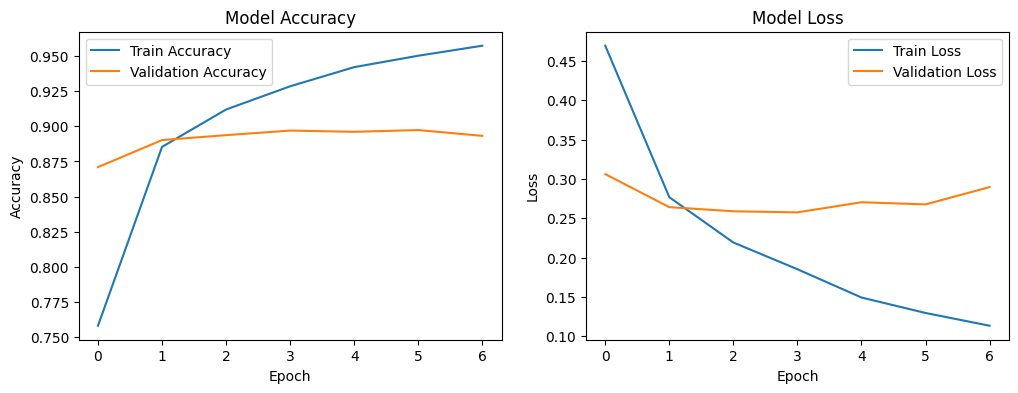

In [11]:
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [15]:
# Save the model in the native Keras format
model.save('sentiment_model.keras')

# Save the tokenizer using pickle
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Load tokenizer and model
from tensorflow.keras.models import load_model
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Load the model
model = load_model('sentiment_model.keras')

# Recompile the model (since the compile state is not saved with the model)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Now you can use the model for prediction or evaluation


In [18]:
# Function to preprocess and predict sentiment
def predict_sentiment(input_text):
    global tokenizer, model
    # Tokenize the input text
    input_seq = tokenizer.texts_to_sequences([input_text])
    # Pad the sequence
    input_padded = pad_sequences(input_seq, maxlen=max_length)
    # Predict the sentiment
    prediction = model.predict(input_padded)
    # Map prediction to sentiment label
    sentiment = 'positive' if prediction[0][0] >= 0.5 else 'negative'
    print(f"Review: {input_text}")
    print(f"Predicted Sentiment: {sentiment} (Confidence: {prediction[0][0]:.4f})")

# Test with a dynamic input
while True:
    user_input = input("Enter a movie review (or type 'exit' to quit): ")
    if user_input.lower() == 'exit':
        break
    predict_sentiment(user_input)


Enter a movie review (or type 'exit' to quit):  i like the movie


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Review: i like the movie
Predicted Sentiment: positive (Confidence: 0.8898)


Enter a movie review (or type 'exit' to quit):  it was an amazing movie


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Review: it was an amazing movie
Predicted Sentiment: positive (Confidence: 0.9901)


Enter a movie review (or type 'exit' to quit):  i didnt like the movie much


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Review: i didnt like the movie much
Predicted Sentiment: negative (Confidence: 0.2437)


Enter a movie review (or type 'exit' to quit):  exit
